# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import tensorflow as tf

### set gpu backend
def setGPU(backend, GPU):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.visible_device_list = GPU
    #session = tf.Session(config=config)
    backend.tensorflow_backend.set_session(tf.Session(config=config))


    
    # select GPU, usually only one
from keras import backend as K

setGPU(K, "0,1,2")
import keras

# from keras import backend as K
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True


Using TensorFlow backend.


In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [3]:
from mrcnn.config import Config

class MouseConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mouse"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    
    GPU_COUNT = 1

class MouseDataset(utils.Dataset):
    
    def load_mouse(self, dataset_dir, subset, annotations):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("mouse", 1, "mouse")

        # Train or validation dataset?
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
#         annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "mouse",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
#         if image_info["source"] != "mouse":
#             return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "mouse":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
            

In [4]:
config = MouseConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
# config.IMAGES_PER_GPU = 1
# config.BACKBONE = 'resnet50'
# config.BACKBONE_STRIDES = [4, 8, 16, 32, 64, 128]

In [6]:
config.IMAGES_PER_GPU = 1
# config.BATCH_SIZE = 
config.FPN_CLASSIF_FC_LAYERS_SIZE = 32

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [8]:
import json
import skimage

In [9]:
annotations_train_1 = json.load(open(os.path.join('/media/nexus/storage3/primate_data/', "via_region_data.json")))
annotations_train_2 = json.load(open(os.path.join('/media/nexus/storage3/primate_data/', "via_region_data_2.json")))

annotations_train = {}
annotations_train.update(annotations_train_1)
annotations_train.update(annotations_train_2)

In [10]:
annotations_val =  dict(random.sample(annotations_train.items(), 15))
for entry in annotations_val.keys():
    del annotations_train[entry]

In [11]:
from shutil import copyfile

for annot in annotations_train.values():
    filename = annot['filename']
    try:
        copyfile('/media/nexus/storage3/primate_data/single_frames/' + filename, 
                 '/media/nexus/storage3/primate_data/annotated_frames/train/' + filename)
    except FileNotFoundError:
        copyfile('/media/nexus/storage3/primate_data/single_frames_2/' + filename, 
                 '/media/nexus/storage3/primate_data/annotated_frames/train/' + filename)

filenames = []
for annot in annotations_val.values():
    filename = annot['filename']
    try:
        copyfile('/media/nexus/storage3/primate_data/single_frames/' + filename, 
                 '/media/nexus/storage3/primate_data/annotated_frames/train/' + filename)
    except FileNotFoundError:
        copyfile('/media/nexus/storage3/primate_data/single_frames_2/' + filename, 
                 '/media/nexus/storage3/primate_data/annotated_frames/train/' + filename)
        
    filenames.append(filename)

In [12]:
config = MouseConfig()
MOUSE_DIR = os.path.join(ROOT_DIR, '/media/nexus/storage3/primate_data/annotated_frames/')

In [13]:
# Training dataset
dataset_train = MouseDataset()
dataset_train.load_mouse(MOUSE_DIR, "train", annotations_train)
dataset_train.prepare()

# # Validation dataset
dataset_val = MouseDataset()
dataset_val.load_mouse(MOUSE_DIR, "train", annotations_val)
dataset_val.prepare()

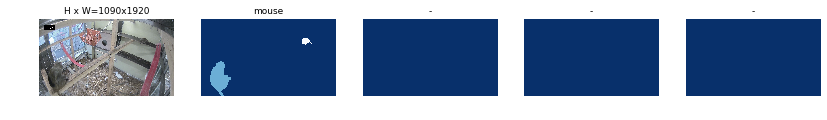

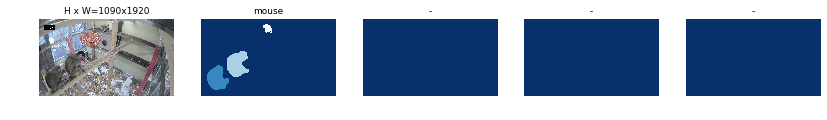

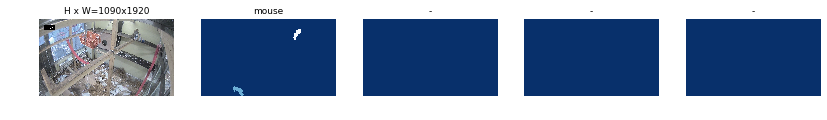

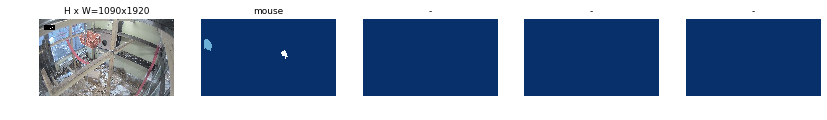

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [19]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [20]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [21]:
sometimes = lambda aug: iaa.Sometimes(0.25, aug)

In [22]:
import imgaug.augmenters as iaa
import imgaug as ia


# augmentation

# https://github.com/aleju/imgaug

In [23]:
# augmentation = imgaug.augmenters.Sometimes(0.5, [
#     imgaug.augmenters.Fliplr(0.5),
#     imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
# ])

augmentation = iaa.Sequential(
        [
        # apply the following augmenters to most images
        iaa.Fliplr(0.25), # horizontally flip 50% of all images\
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.Affine(
            scale={"x": (0.5, 1.5), "y": (0.5, 1.5)}, # scale images to 80-120% of their size, individually per axis
            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        ],
    random_order=True
)

In [24]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=12, 
            layers='heads',
            augmentation=augmentation,
#            validation_split = 0.2,
           )


Starting at epoch 0. LR=0.001

Checkpoint Path: /media/nexus/storage4/github/Mask_RCNN/logs/mouse20190822T1947/mask_rcnn_mouse_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribu

/home/nexus/anaconda2/envs/pbt-keras36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/nexus/anaconda2/envs/pbt-keras36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/12
100/100 [==============================] - 333s 3s/step - loss: 1.4588 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 0.3965 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.5254 - val_loss: 1.3239 - val_rpn_class_loss: 0.0419 - val_rpn_bbox_loss: 0.3556 - val_mrcnn_class_loss: 0.0907 - val_mrcnn_bbox_loss: 0.4990 - val_mrcnn_mask_loss: 0.3367
Epoch 2/12
100/100 [==============================] - 282s 3s/step - loss: 1.2009 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.5085 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.2596 - mrcnn_mask_loss: 0.2943 - val_loss: 1.0998 - val_rpn_class_loss: 0.0207 - val_rpn_bbox_loss: 0.3772 - val_mrcnn_class_loss: 0.0600 - val_mrcnn_bbox_loss: 0.3132 - val_mrcnn_mask_loss: 0.3286
Epoch 3/12
100/100 [==============================] - 282s 3s/step - loss: 0.7776 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.1959 - mrcnn_mask_loss: 0.2137 - val_loss: 0.9772 - val_rpn_class_l

In [63]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")


Starting at epoch 12. LR=0.0001

Checkpoint Path: /media/nexus/storage4/github/Mask_RCNN/logs/mouse20190822T1947/mask_rcnn_mouse_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (C

/home/nexus/anaconda2/envs/pbt-keras36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/nexus/anaconda2/envs/pbt-keras36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 13/20
100/100 [==============================] - 274s 3s/step - loss: 0.5236 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1645 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1855 - val_loss: 0.9287 - val_rpn_class_loss: 0.0129 - val_rpn_bbox_loss: 0.3753 - val_mrcnn_class_loss: 0.0631 - val_mrcnn_bbox_loss: 0.2237 - val_mrcnn_mask_loss: 0.2537
Epoch 14/20
100/100 [==============================] - 226s 2s/step - loss: 0.5931 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.2234 - val_loss: 0.9620 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.2637 - val_mrcnn_class_loss: 0.0473 - val_mrcnn_bbox_loss: 0.3222 - val_mrcnn_mask_loss: 0.3184
Epoch 15/20
100/100 [==============================] - 226s 2s/step - loss: 0.4796 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.1883 - val_loss: 1.2271 - val_rpn_clas

In [ ]:
print('done')

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [68]:
class InferenceConfig(MouseConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /media/nexus/storage4/github/Mask_RCNN/logs/mouse20190822T1947/mask_rcnn_mouse_0020.h5
Re-starting from epoch 20


In [69]:
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1920.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  277.00000  max:  765.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


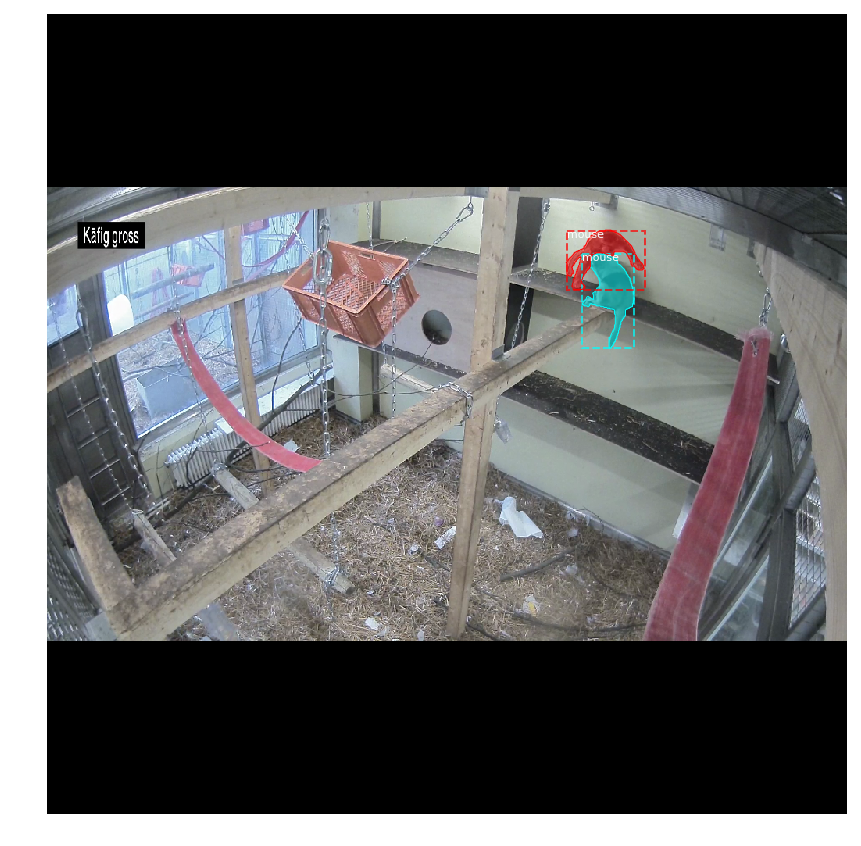

In [103]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(15,15))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


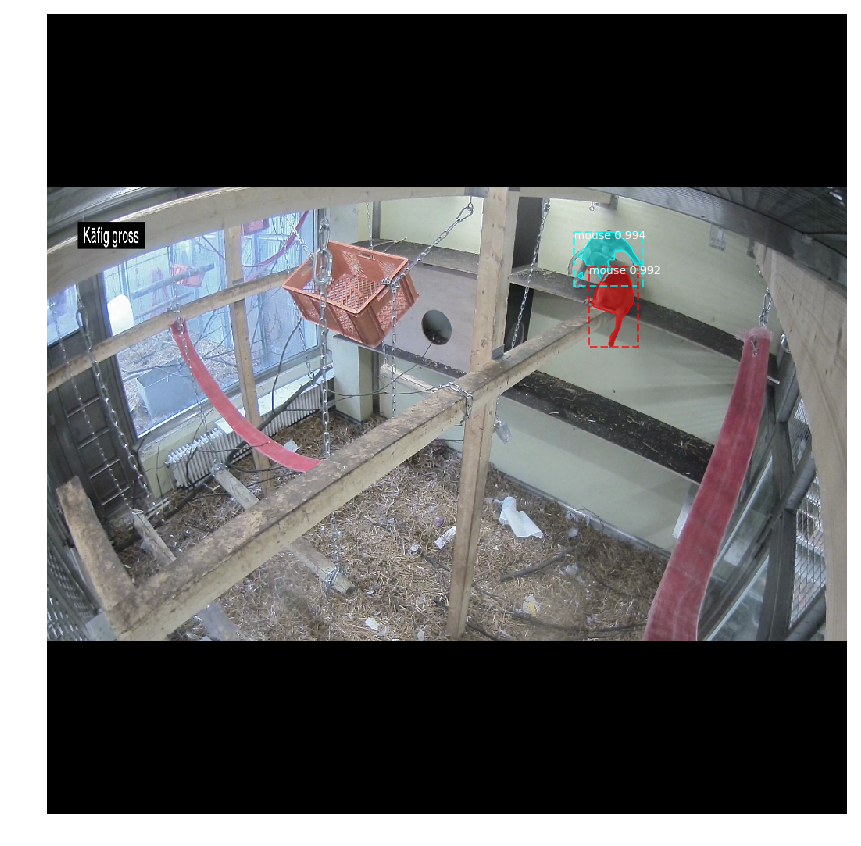

In [104]:
results = model.detect([original_image], verbose=1)

r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'], ax=get_ax(),figsize=(15,15))

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(15,15))

In [ ]:
for res in results:
    print(res['scores'])

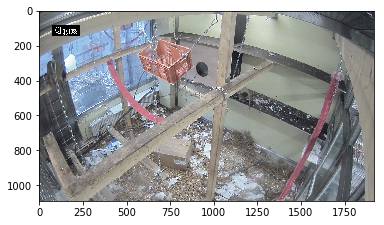

In [30]:
plt.imshow(image)

## Evaluation

In [94]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9166666686534881


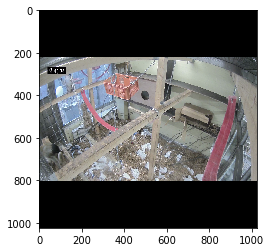

In [95]:
plt.imshow(image)

In [96]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   35.88955  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   41.27741  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   67.40588  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -11.62203  max:   61.80388  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


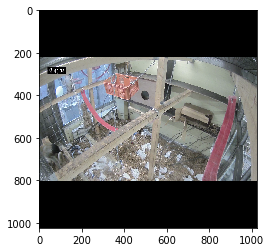

In [97]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [98]:
from mrcnn import visualize
from mrcnn.visualize import display_images

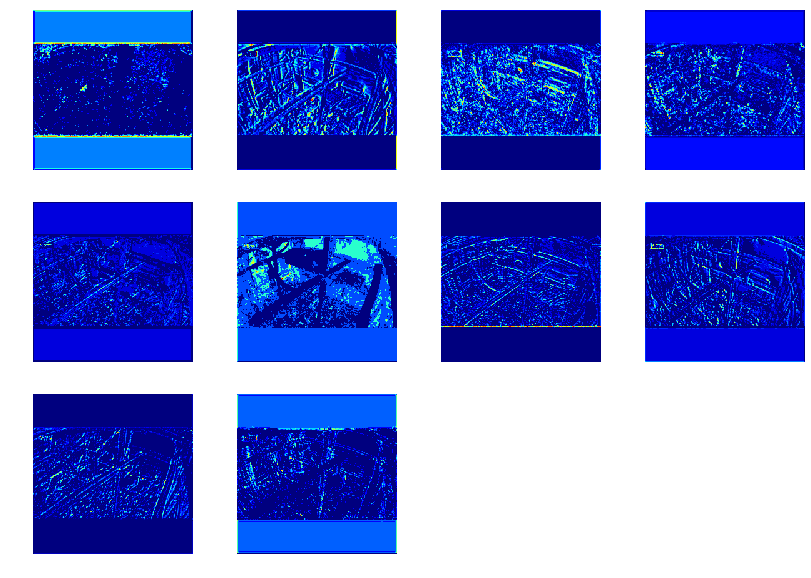

In [99]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:10], [2, 0, 1]), cols=4, cmap='jet')

# extract bounding boxes

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


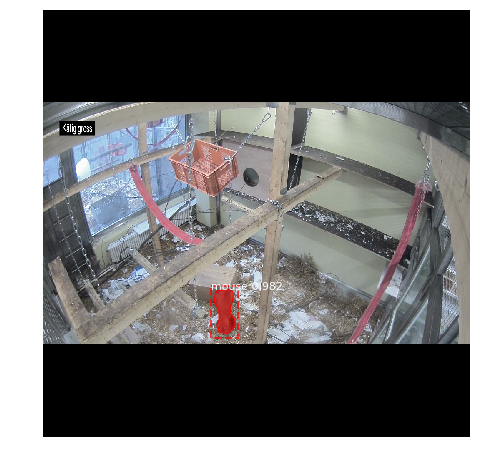

In [100]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [101]:
get_img = original_image[r['rois'][0][0]:r['rois'][0][2],r['rois'][0][1]:r['rois'][0][3]]

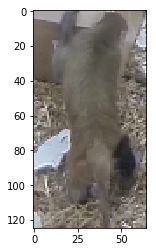

In [102]:
plt.imshow(get_img)

In [105]:
from tqdm import tqdm

In [106]:
import skvideo.io
from skimage.io import imsave, imread

In [107]:
filename = '20180131T135402-20180131T142501_%T1'

In [108]:
# save hier segmented images

sink  = '/media/nexus/storage3/primate_data/preprocessed/segmented/'



In [ ]:
videodata = skvideo.io.vread('/media/nexus/storage3/primate_data/Markus/'+filename+'.mp4', as_grey=False)
print(videodata.shape)

In [ ]:
from mrcnn.utils import resize_image

In [ ]:
results = []
imgs = []

for idx, img in tqdm(enumerate(videodata[:5000])):
    image, window, scale, padding, crop = utils.resize_image(
        img[:,:,:],
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)
    vid_results = model.detect([image], verbose=1)
    r = vid_results[0]
    results.append(r)
    
    # save current frame
    np.save(sink + 'frames_new/' + filename + '_frame_'+ str(idx) +'.npy', image)
    
    # visualize
#     fig, ax = plt.subplots(figsize=(10,10))
#     visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset_val.class_names, r['scores'], ax=ax)
#     fig.savefig('./movie/img'+str(idx)+'.png')

In [ ]:
plt.imshow(results[0]['masks'][:,:,0])

In [ ]:
# results = np.asarray(results)
np.save(sink + filename + '_SegResults.npy', results)

In [ ]:
imgs = np.asarray(imgs)


In [ ]:
np.save(sink + filename + '_frames.npy', imgs)


In [ ]:
print('done')

In [ ]:
plt.imshow(videodata[0])

In [ ]:
from matplotlib import patches,  lines

In [ ]:
y1, x1, y2, x2 = results[0]['rois'][0]
_, ax = plt.subplots(1, figsize=(20,20))
ax.imshow(imgs[0])
p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                    alpha=0.7, linestyle="dashed",
                    edgecolor='red', facecolor='none')
ax.add_patch(p)

In [ ]:
imgs[0].shape

In [ ]:
%matplotlib inline
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib import animation

fontsize = 15
fig, axes = plt.subplots(6,1, figsize=(15,15))
pl1, = axes[0].plot([], [], lw=2)
axes[0].set_title('filtered_transients', fontsize=fontsize)
pl2, = axes[1].plot([], [], lw=2)
axes[1].set_title('decoded activity', fontsize=fontsize)
axes[1].plot([], [], lw=2)
pl3, = axes[2].plot([], [], lw=2)
axes[2].set_title('mapped activity', fontsize=fontsize)
pl4, = axes[3].plot([], [], lw=2)
axes[3].set_title('auditory cursor', fontsize=fontsize)
pl5, = axes[4].plot([], [], lw=2)
axes[4].set_title('rewards', fontsize=fontsize)
pl6, = axes[5].plot([], [], lw=2)
axes[5].set_title('trial status', fontsize=fontsize)
fig.tight_layout()


x = np.arange(0,5000,1)

line = [pl1,pl2,pl3,pl4,pl5,pl6]
for ax in axes:
    ax.set_xlim(( 0, len(x)))
    ax.set_ylim((0, 1))
    
axes[1].set_ylim((0, 2))
axes[2].set_ylim((0, 100000))
axes[3].set_ylim((2000, 20000))

# initialization function: plot the background of each frame
def init():
#     line[0].set_data([], [])
    line[1].set_data([], [])
    line[2].set_data([], [])
    line[3].set_data([], [])
    line[4].set_data([], [])
    line[5].set_data([], [])
    return line

# animation function. This is called sequentially
def animate(i):
#     line[0].set_data(x[:i], transient[:i,0])
    line[1].set_data(x[:i], decoded[:i])
    line[2].set_data(x[:i], mapped[:i])
    line[3].set_data(x[:i], to_octaved[:i])
    line[4].set_data(x[:i], reward[:i])
    line[5].set_data(x[:i], state[:i])
    return line

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(x), interval=20, blit=True)

# HTML(anim.to_html5_video())

In [ ]:
# test = '/media/nexus/storage3/BEHAVIORDECODING_main/2019-05-28_Mouse_ID_3mice_00naivebehavior/data_manta/'

test = '/media/nexus/storage3/BEHAVIORDECODING_main/2019-05-27_Mouse_ID_3_00naivebehavior/data_manta/'


In [ ]:
from glob import glob

In [ ]:
files = glob(test + "*.npy")

In [ ]:
# func
def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [ ]:
files.sort(key=natural_keys)

In [ ]:
import numpy as np

In [ ]:
import os.path
import numpy as np
from PIL import Image



def numpy2pil(np_array: np.ndarray) -> Image:
    """
    Convert an HxWx3 numpy array into an RGB Image
    """

    assert_msg = 'Input shall be a HxWx3 ndarray'
    assert isinstance(np_array, np.ndarray), assert_msg
    assert len(np_array.shape) == 3, assert_msg
    assert np_array.shape[2] == 3, assert_msg

    img = Image.fromarray(np_array, 'RGB')
    return img


In [ ]:

a = np.load(files[3333])[140:255,75:625]
img = [a]*3

img = np.asarray(img)

img = np.swapaxes(img, 0, 1)
img = np.swapaxes(img, 1, 2)

In [ ]:
plt.imshow(img[:,:,2])

In [ ]:
from tqdm import tqdm

In [ ]:
length = 200

In [ ]:
imgs = np.zeros((length, 125,300,3))

In [ ]:
imgs.shape

In [ ]:



# imgs = []

for i in tqdm(range(0,length)):
    

    a = np.load(files[i])[140:255,75:625]
    img = [a]*3

    img = np.asarray(img)

    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    
    results = model.detect([img], verbose=1)
    try:
        print('yo')
        r = results[0]
        r['rois'][0]
        
        y1 = r['rois'][0][2] - r['rois'][0][0]
        y2 = r['rois'][0][3] - r['rois'][0][1]
        
        imgs[i,:y1,:y2,:] = img[r['rois'][0][0]:r['rois'][0][2],r['rois'][0][1]:r['rois'][0][3]]
    except IndexError:
        continue

    

In [ ]:
imgs = np.asarray(imgs).astype('uint8')

In [ ]:
plt.imshow(imgs[88])

In [ ]:
display_images(imgs[:96], cols=4, cmap='jet')

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open(path_animal_1, 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")